In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

from custom_data_manager import AugmentationManager
from custom_data_manager import CustomDataCollector
from custom_data_manager import CustomDataLoader
from custom_data_manager import DataGeneratorBuilder
from model_manager import ModelManager

from utils import *

In [3]:
IMG_SIZE=96

In [21]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices([], 'GPU')
#     except RuntimeError as e:
#         # Visible devices must be set at program startup
#         print(e)

# tf.config.get_visible_devices()

## Prepare

In [22]:
#Takes long time
custom_ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"

sub_dirs_to_load = ['0006', '0009', 
                    '0010','0011', '0012', '0018', '0024', 
                    '0030', '0037', '0038','0050', '0054','0056','0059','0077','0081',
                    '0083','0086','0088'
                   ]

#sub_dirs_to_load = ['0006', '0009','0010','0011','0012', '0018','0024','0030', 
#                    '0037', '0038','0050', '0054','0077','0081']



In [23]:
data_collector = CustomDataCollector(IMG_SIZE, sub_dirs_to_load, custom_ycb_path)
data_collector.collect()
frames_poses_dict = data_collector.frames_poses_dict

0006
0009
0010
0011
0012
0018
0024
0030
0037
0038
0050
0054
0056
0059
0077
0081
0083
0086
0088


In [212]:
train_types = ['0006', '0011',
                    '0010', '0018', '0030', 
                    '0037', '0038','0050', '0054','0056','0059','0077','0081',
                    '0083','0086','0088'
                   ]


val_types = ['0009','0012','0024']

In [213]:
k = 3
aug_pipeline = [
        {"aug_type": "channel_shift", "parameters": []},
        {"aug_type": "rotation", "parameters": [60]},
        {"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [13*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
    
        {"aug_type": "rotation", "parameters": [60]},
        #{"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [50*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [25*k, 0.07, True]},
        {"aug_type": "random_rectangles", "parameters": [12*k, 0.2, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.2, True]},
        #{"aug_type": "random_rectangles", "parameters": [2, 0.5, True]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.4, False]},
        {"aug_type": "random_rectangles", "parameters": [7*k, 0.8, False]},
        {"aug_type": "channel_shift", "parameters": []},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [214]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

## Generators

In [215]:
train_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, train_types, aug = True)
train_generator = train_generator_builder.generator
tf_train_generator = train_generator_builder.build_tf_generator()

val_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, val_types, aug = False)
val_generator = val_generator_builder.generator
tf_val_generator = val_generator_builder.build_tf_generator()

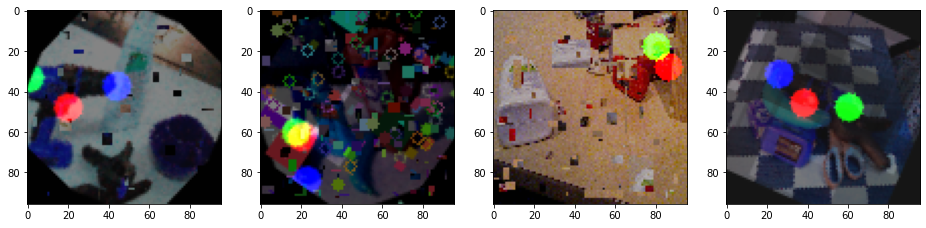

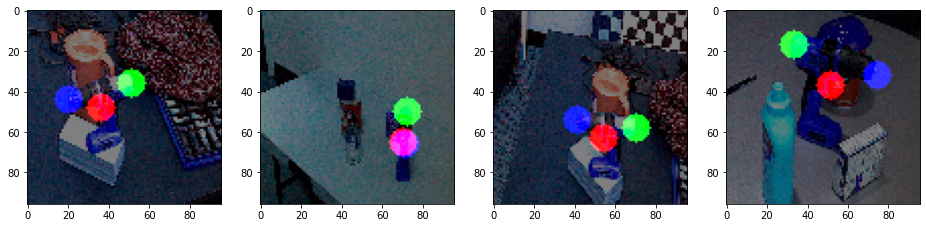

In [229]:
visualize_image_data(train_generator)
visualize_image_data(val_generator)

## Define Model

In [230]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model_hourglass_2_blocks(IMG_SIZE)

In [231]:
#model.summary()

In [232]:
def get_generator_images(generator, probes):
    images = []
    for _ in range(probes):
        frame, mask = next(generator)
        images.append(frame)
    return images

In [233]:
train_images = get_generator_images(train_generator, 16)
val_images = get_generator_images(val_generator, 16)

## Save Results

In [234]:
def save_plots(train_history, experiment_path):

    
    train_oks = [x[0] for x in train_history]
    val_oks = [x[1] for x in train_history]
    train_pdj = [x[2] for x in train_history]
    val_pdj = [x[3] for x in train_history]
    train_loss = [x[4] for x in train_history]
    val_loss = [x[5] for x in train_history]
    
    plt.plot(train_oks, label='train')
    plt.plot(val_oks, label='val')
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("OKS metric %")
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_oks.png'))
    plt.close()

    plt.plot(train_pdj, label='train')
    plt.plot(val_pdj, label='val')
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("PDJ metric")
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_pdj.png'))
    plt.close()
    
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_loss.png'))
    plt.close()


        
def save_predicted_masks(model, train_images, val_images, experiment_train_images_path, experiment_val_images_path):
    train_images = np.array(train_images)
    val_images = np.array(val_images)
    train_predicted_masks = model.predict(train_images)
    val_predicted_masks = model.predict(val_images)
    
    fig = plt.figure(figsize=(16, 16))
    rows = 4
    columns = 4

    for i in range(16):
        img = train_images[i]
        mask = train_predicted_masks[1][i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_train_images_path)
    plt.close() 
    
    fig = plt.figure(figsize=(16, 16))
    rows = 4
    columns = 4
    for i in range(16):
        img = val_images[i]
        mask = val_predicted_masks[1][i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_val_images_path)
    plt.close() 

def save_results(train_history,model, train_images, val_images, epoch, experiment_name):

    
    results_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\repo\\Pose-estimation-hourglass\\rgbd_ycb\\results"
    experiment_path = os.path.join(results_path, experiment_name)
    experiment_train_images_path = os.path.join(results_path, experiment_name, "train_images")
    experiment_val_images_path = os.path.join(results_path, experiment_name, "val_images")
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_train_images_path):
        os.makedirs(experiment_train_images_path)
    if not os.path.exists(experiment_val_images_path):
        os.makedirs(experiment_val_images_path)
    
    experiment_train_images_path = os.path.join(experiment_train_images_path,f"epoch_{epoch}.png")
    experiment_val_images_path = os.path.join(experiment_val_images_path,f"epoch_{epoch}.png")
    save_plots(train_history, experiment_path)
    save_predicted_masks(model, 
                         train_images, 
                         val_images, 
                         experiment_train_images_path, 
                         experiment_val_images_path)
    


In [235]:
train_history = []

In [239]:
m_calc = MetricsCalculator()
#m_calc.calc_oks_metric(model,val_generator, 100)

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 21
        train_oks = m_calc.calc_oks_metric(model,train_generator, 50)*100/IMG_SIZE
        val_oks = m_calc.calc_oks_metric(model,val_generator, 50)*100/IMG_SIZE
        train_pdj = m_calc.calc_pdj_metric(model,train_generator, 50)
        val_pdj = m_calc.calc_pdj_metric(model,val_generator, 50)
        train_loss = logs.get("head2_loss")
        val_loss = model.evaluate(tf_val_generator)[2]
        train_history.append((train_oks,val_oks,train_pdj,val_pdj,train_loss,val_loss))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks, "train_pdj:", train_pdj, "val_pdj:",val_pdj, "train_loss", train_loss)
        save_results(train_history,model, train_images, val_images, epoch, "hourglass_different_aug_v3_stronger_aug_better_val")
        return None

## Train

In [240]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss = {"head1": "mse", "head2": "mse"})

In [241]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 32,
           callbacks=[my_callback()]
           )

Epoch 1/100
38/38 [==============================] - 4s 79ms/step - loss: 0.0313 - head1_loss: 0.0157 - head2_loss: 0.0156

train_oks: 28.00710284068227 val_oks: 24.420500046688616 train_pdj: 0.02 val_pdj: 0.022857142857142857 train_loss 0.017735252156853676
223/223 [==============================] - 63s 260ms/step - loss: 0.0389 - head1_loss: 0.0212 - head2_loss: 0.0177
Epoch 2/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0309 - head1_loss: 0.0155 - head2_loss: 0.0155

train_oks: 23.71985208772358 val_oks: 22.904340149912045 train_pdj: 0.02571428571428571 val_pdj: 0.02571428571428571 train_loss 0.013591269962489605
223/223 [==============================] - 55s 244ms/step - loss: 0.0275 - head1_loss: 0.0139 - head2_loss: 0.0136
Epoch 3/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0294 - head1_loss: 0.0155 - head2_loss: 0.0140

train_oks: 23.56113556896285 val_oks: 14.258766345815118 train_pdj: 0.07142857142857142 val_pdj: 0.131428571428571

223/223 [==============================] - 56s 249ms/step - loss: 0.0211 - head1_loss: 0.0116 - head2_loss: 0.0094
Epoch 18/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0269 - head1_loss: 0.0133 - head2_loss: 0.0136

train_oks: 9.15123133437425 val_oks: 10.264405025602814 train_pdj: 0.6857142857142855 val_pdj: 0.32857142857142846 train_loss 0.009177356958389282
223/223 [==============================] - 55s 247ms/step - loss: 0.0205 - head1_loss: 0.0114 - head2_loss: 0.0092
Epoch 19/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0278 - head1_loss: 0.0138 - head2_loss: 0.0140

train_oks: 6.6234031793212536 val_oks: 10.726534209643335 train_pdj: 0.5285714285714285 val_pdj: 0.2457142857142857 train_loss 0.008990861475467682
223/223 [==============================] - 55s 247ms/step - loss: 0.0201 - head1_loss: 0.0111 - head2_loss: 0.0090
Epoch 20/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0265 - head1_loss: 0.0139 - head2

223/223 [==============================] - 55s 248ms/step - loss: 0.0156 - head1_loss: 0.0086 - head2_loss: 0.0070
Epoch 35/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0279 - head1_loss: 0.0145 - head2_loss: 0.0134

train_oks: 5.437410345231156 val_oks: 10.994862143405456 train_pdj: 0.7342857142857142 val_pdj: 0.28857142857142853 train_loss 0.007074839901179075
223/223 [==============================] - 56s 250ms/step - loss: 0.0156 - head1_loss: 0.0085 - head2_loss: 0.0071
Epoch 36/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0266 - head1_loss: 0.0138 - head2_loss: 0.0128

train_oks: 4.364680311246153 val_oks: 10.814807031258688 train_pdj: 0.7628571428571428 val_pdj: 0.3257142857142857 train_loss 0.0068391296081244946
223/223 [==============================] - 56s 250ms/step - loss: 0.0152 - head1_loss: 0.0084 - head2_loss: 0.0068
Epoch 37/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0279 - head1_loss: 0.0144 - head

KeyboardInterrupt: 

## Evaulate

In [ ]:
def save_results_2(model, train_images):
    experiment_name = "test"
    
    results_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\repo\\Pose-estimation-hourglass\\rgbd_ycb\\results"
    experiment_path = os.path.join(results_path, experiment_name)
    experiment_train_images_path = os.path.join(results_path, experiment_name, "train_images")
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_train_images_path):
        os.makedirs(experiment_train_images_path)
    
    experiment_train_images_path = os.path.join(experiment_train_images_path,f"epoch.png")
    save_predicted_masks(model, 
                         train_images, 
                         train_images, 
                         experiment_train_images_path, 
                         experiment_train_images_path)

In [ ]:
train_images_test = get_generator_images(val_generator, 9)
save_results_2(model, train_images_test)